## TM Benchmarks Relative Precision Tests

### Univariate cases

- [sine](#sine)
- [bspline0](#bspline0)
- [bspline1](#bspline1)
- [bspline2](#bspline2)
- [bspline3](#bspline3)

### Multivariate cases

- [Himmilbeau](#Himmilbeau)
- [Kepler1](#Kepler1)
- [Kepler2](#Kepler2)
- [Kepler3](#Kepler3)
- [RigidBody1](#RigidBody1)
- [RigidBody2](#RigidBody2)


### Final results

See the table in the [Results](#Results) section.

## Setup

In [39]:
# dependencies
using SumOfSquares, DynamicPolynomials, SemialgebraicSets, MosekTools, SDPA
using Plots
using TaylorModels
using AffineArithmetic

In [40]:
# domains
a = Interval(-4.5, -0.3)
b = Interval(0.4, 0.9)
c = Interval(3.8, 7.8)
d = Interval(8.0, 10.0)
e = Interval(-10.0, 8.0)
f = Interval(1.0, 2.0)

# fix the order for the series expansions
ord = 2

REF = Dict()
RELPREC = Dict()

Dict{Any,Any} with 0 entries

## Appendix I

In [41]:
# This function measures the relative precision of the result in a more informative way than
# taking the scalar overestimation because it evaluates the precision of the lower and the
# upper range bounds separately, see Eq. (20) in [1].
function relative_precision(x, x_ref)
    x_low, x_high = inf(x), sup(x)
    x_ref_low, x_ref_high = inf(x_ref), sup(x_ref)
    rel_low = -(x_low - x_ref_low) / (x_ref_high - x_ref_low)
    rel_high = (x_high - x_ref_high) / (x_ref_high - x_ref_low)
    return 100 * Interval(rel_low, rel_high)
end

relative_precision (generic function with 1 method)

## Appendix II

In [42]:
const available_algorithms = ["AA", "IA", "TM", "TM_NORM", "SDP", "ZOO"];

In [43]:
# This function returns an overapproximation of the range of `f`
# using different methods
function bounds(f::Function, dom::Union{Interval, IntervalBox}; algorithm="ZOO", order=2)::Interval

    numvars = length(dom)
    if algorithm == "IA"
        bnd = _bounds_IA(f, dom)
    elseif algorithm == "TM"
        bnd = _bounds_TM(f, dom, order)
    elseif algorithm == "TM_NORM"
        bnd = _bounds_TM_NORM(f, dom, order)
    elseif algorithm == "AA"
        bnd = _bounds_AA(f, dom)
    elseif algorithm == "SDP"
        bnd = _bounds_SDP(f, dom, order)
    elseif algorithm == "ZOO"
        algos = setdiff(available_algorithms, ["ZOO", "SDP"])
        bnd_all = [bounds(f, dom, algorithm=a, order=order) for a in algos]
        bnd = reduce(∩, bnd_all)
    else
        error("algorithm $algorithm unknown")
    end
    return bnd
end

bounds (generic function with 1 method)

In [44]:
# interval arithmetic substitution
function _bounds_IA(f, dom)
    return f(dom...)
end

# affine arithmetic substitution
function _bounds_AA(f::Function, dom::Interval)
    x = AFF(dom, 1, 1)
    return interval(f(x))
end

# affine arithmetic in N variables
function _bounds_AA(f::Function, dom::IntervalBox{N}) where {N}
    x = [AFF(dom[i], N, i) for i in 1:N]
    return interval(f(x...))
end

# taylor model in one variable
function _bounds_TM(f::Function, dom::Interval, order::Int)
    x0 = Interval(mid(dom))
    x = TaylorModel1(order, x0, dom)
    return evaluate(f(x), dom - x0)
end

# normalized taylor model in one variable
function _bounds_TM_NORM(f::Function, dom::Interval, order::Int)
    x0 = Interval(mid(dom))
    x = TaylorModel1(order, x0, dom)
    xnorm = normalize_taylor(x.pol, dom - x0, true)
    xnormTM = TaylorModel1(xnorm, 0..0, 0..0, -1..1)
    return evaluate(f(xnormTM), -1..1)
end

# taylor model in N variables
function _bounds_TM(f::Function, dom::IntervalBox{N}, order) where {N}
    x0 = mid(dom)
    set_variables(Float64, "x", order=2order, numvars=N)
    x = [TaylorModelN(i, ord, IntervalBox(x0), dom) for i=1:N]
    return evaluate(f(x...), dom - x0)
end

# normalized taylor model in N variables
function _bounds_TM_NORM(f::Function, dom::IntervalBox{N}, order::Int) where {N}
    x0 = mid(dom)
    set_variables(Float64, "x", order=2order, numvars=N)

    zeroBox = IntervalBox(0..0, N)
    symBox = IntervalBox(-1..1, N)
    
    x = [TaylorModelN(i, ord, IntervalBox(x0), dom) for i=1:N]
    xnorm = [normalize_taylor(xi.pol, dom - x0, true) for xi in x]
    xnormTM = [TaylorModelN(xi_norm, 0..0, zeroBox, symBox) for xi_norm in xnorm]
    return evaluate(f(xnormTM...), symBox)
end

_bounds_TM_NORM (generic function with 2 methods)

In [45]:
function new_sos(backend, verbose)
    if backend == "Mosek"
        model = SOSModel(with_optimizer(Mosek.Optimizer, QUIET=!verbose))
    elseif backend == "SDPA"
        model = SOSModel(with_optimizer(SDPA.Optimizer))
    else
        error("backend $backend not supported")
    end
    return model
end

# to get runtime:
# MOI.get(model, MOI.SolveTime())
function _bounds_SDP(f::Function, dom::Interval, order::Int; backend="Mosek", verbose=false)

    # polynomial variables
    @polyvar x
    p = f(x)

    # box constraints
    B = @set inf(dom) <= x && x <= sup(dom)

    # ============
    # Upper bound
    # ============ 
    model = new_sos(backend, verbose)
    @variable(model, γ) # JuMP decision variable
    @constraint(model, p <= γ, domain=B, maxdegree=order)
    @objective(model, Min, γ)
    optimize!(model)
    upper_bound = objective_value(model)

    # ============
    # Lower bound
    # ============
    model = new_sos(backend, verbose)
    @variable(model, γ) # JuMP decision variable
    @constraint(model, p >= γ, domain=B, maxdegree=order)
    @objective(model, Max, γ)
    optimize!(model)
    lower_bound = objective_value(model)

    return Interval(lower_bound, upper_bound)

end

function _bounds_SDP(f::Function, dom::IntervalBox{N}, order::Int; backend="Mosek", verbose=false) where {N}
    
    # polynomial variables
    @polyvar x[1:N]
    p = f(x...)

    # box constraints
    Bi =[@set inf(dom[i]) <= x[i] && x[i] <= sup(dom[i]) for i in 1:N]
    B = reduce(intersect, Bi)

    # ============
    # Upper bound
    # ============ 
    model = new_sos(backend, verbose)
    @variable(model, γ) # JuMP decision variable
    @constraint(model, p <= γ, domain=B, maxdegree=order)
    @objective(model, Min, γ)
    optimize!(model)
    upper_bound = objective_value(model)

    # ============
    # Lower bound
    # ============
    model = new_sos(backend, verbose)
    @variable(model, γ) # JuMP decision variable
    @constraint(model, p >= γ, domain=B, maxdegree=order)
    @objective(model, Max, γ)
    optimize!(model)
    lower_bound = objective_value(model)

    return Interval(lower_bound, upper_bound)
end

#=
for a in available_algorithms
    try
        bnd = bounds(sin, dom, algorithm=a)
        println("algorithm = $a, bnd = $bnd")
    catch
        continue
    end
end
=#

_bounds_SDP (generic function with 2 methods)

## sine

REF[model_name] = Interval(min_bound, max_bound) = [-1, 0.977531]


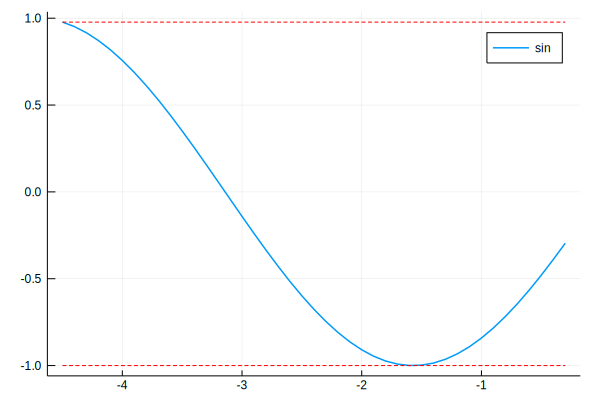

In [46]:
model_name = "sin"
dom = a

min_bound = -1.0
max_bound = sin(inf(a));
@show REF[model_name] = Interval(min_bound, max_bound)

plot(x -> sin(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:topright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [47]:
# using interval arithmetic substitution
@show bnd = bounds(sin, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(sin, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(sin, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name]);

# affine arithmetic and SDP are not available for sin(x)

bnd = bounds(sin, dom, algorithm="IA") = [-1, 0.977531]
bnd = bounds(sin, dom, algorithm="TM") = [-5.25689, 3.90596]
bnd = bounds(sin, dom, algorithm="TM_NORM") = [-3.76749, 3.90596]


## bspline0

REF[model_name] = Interval(min_bound, max_bound) = [0.366166, 27.7292]


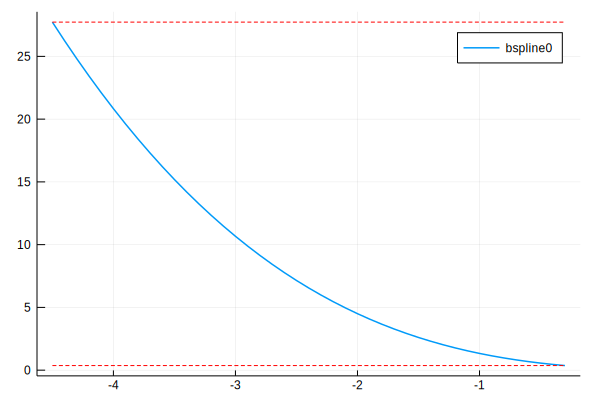

In [48]:
model_name = "bspline0"
dom = a

bspline0(x) = (1 - x) * (1 - x) * (1 - x) / 6.0

# evaluation at the extreme points
min_bound, max_bound = bspline0(sup(a)), bspline0(inf(a))
@show REF[model_name] = Interval(min_bound, max_bound)

plot(x -> bspline0(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [49]:
# using interval arithmetic substitution
@show bnd = bounds(bspline0, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(bspline0, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(bspline0, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(bspline0, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

# using SDP
@show bnd = bounds(bspline0, dom, algorithm="SDP", order=5)
RELPREC[model_name, "SDP"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(bspline0, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(bspline0, dom, algorithm="IA") = [0.366166, 27.7292]
bnd = bounds(bspline0, dom, algorithm="TM") = [-14.6279, 27.7292]
bnd = bounds(bspline0, dom, algorithm="TM_NORM") = [-7.13084, 27.7292]
bnd = bounds(bspline0, dom, algorithm="AA") = [0.366166, 27.7292]
bnd = bounds(bspline0, dom, algorithm="SDP", order=5) = [0.366166, 27.7292]
bnd = bounds(bspline0, dom, algorithm="ZOO") = [0.366166, 27.7292]


## bspline1

REF[model_name] = Interval(min_bound, max_bound) = [-65.1459, 0.563167]


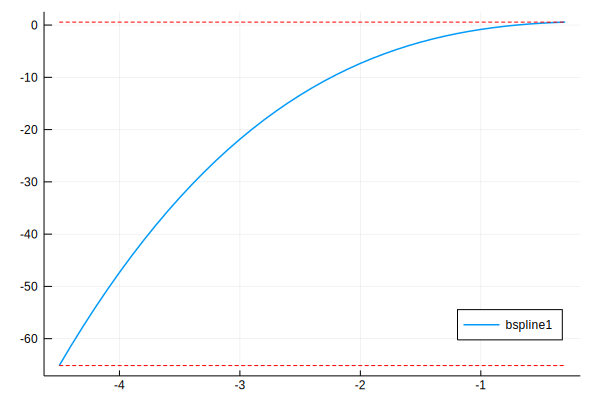

In [50]:
model_name = "bspline1"
dom = a

bspline1(x) = (3*x*x*x - 6*x*x + 4) / 6.0

# evaluation at the extreme points
min_bound, max_bound = bspline1(inf(a)), bspline1(sup(a))
@show REF[model_name] = Interval(min_bound, max_bound)

plot(x -> bspline1(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [51]:
# using interval arithmetic substitution
@show bnd = bounds(bspline1, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(bspline1, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(bspline1, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(bspline1, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

# using SDP
@show bnd = bounds(bspline1, dom, algorithm="SDP", order=5)
RELPREC[model_name, "SDP"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(bspline1, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(bspline1, dom, algorithm="IA") = [-65.1459, 0.563167]
bnd = bounds(bspline1, dom, algorithm="TM") = [-65.1459, 41.1352]
bnd = bounds(bspline1, dom, algorithm="TM_NORM") = [-65.1459, 20.8492]
bnd = bounds(bspline1, dom, algorithm="AA") = [-55.8849, 0.563167]
bnd = bounds(bspline1, dom, algorithm="SDP", order=5) = [-65.1459, 0.563167]
bnd = bounds(bspline1, dom, algorithm="ZOO") = [-55.8849, 0.563167]


## bspline2

REF[model_name] = Interval(min_bound, max_bound) = [0.0751666, 53.6042]


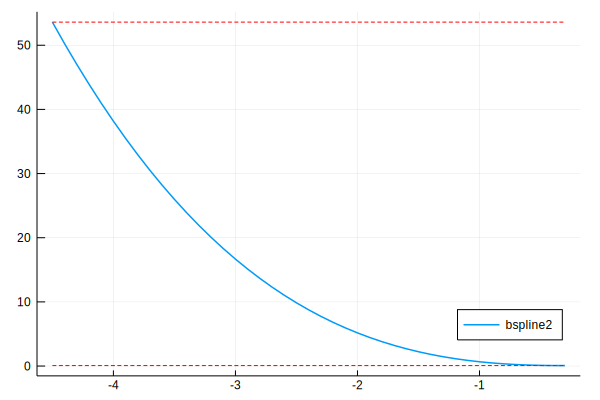

In [52]:
model_name = "bspline2"
dom = a

bspline2(x) = (-3*x*x*x  + 3*x*x + 3*x + 1) / 6.0

# evaluation at the extreme points
min_bound, max_bound = bspline2(sup(a)),bspline2(inf(a))
@show REF[model_name] = Interval(min_bound, max_bound)

plot(x -> bspline2(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [53]:
# using interval arithmetic substitution
@show bnd = bounds(bspline2, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(bspline2, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(bspline2, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(bspline2, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

# using SDP
@show bnd = bounds(bspline2, dom, algorithm="SDP", order=5)
RELPREC[model_name, "SDP"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(bspline2, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(bspline2, dom, algorithm="IA") = [-2.02484, 55.7042]
bnd = bounds(bspline2, dom, algorithm="TM") = [-36.0869, 53.6042]
bnd = bounds(bspline2, dom, algorithm="TM_NORM") = [-18.0059, 53.6042]
bnd = bounds(bspline2, dom, algorithm="AA") = [-2.02484, 44.3432]
bnd = bounds(bspline2, dom, algorithm="SDP", order=5) = [0.074074, 53.6042]
bnd = bounds(bspline2, dom, algorithm="ZOO") = [-2.02484, 44.3432]


## bspline3

REF[model_name] = Interval(min_bound, max_bound) = [0.00449999, 15.1875]


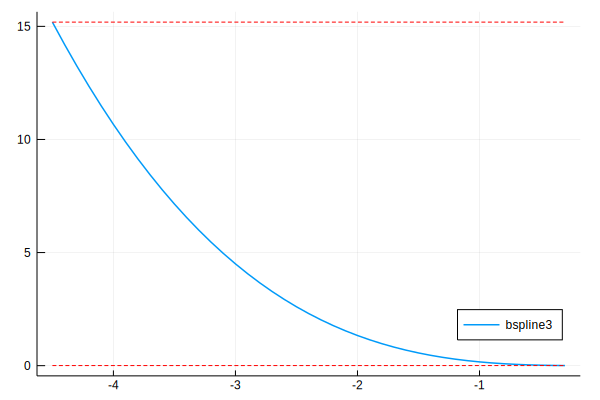

In [54]:
model_name = "bspline3"
dom = a

bspline3(x) = -x*x*x / 6.0

# evaluation at the extreme points
min_bound, max_bound = bspline3(sup(a)), bspline3(inf(a))
@show REF[model_name] = Interval(min_bound, max_bound)

plot(x -> bspline3(x), inf(dom):0.1:sup(dom), lw=1.5, lab=model_name, legend=:bottomright)
plot!(x -> min_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")
plot!(x -> max_bound, inf(dom):0.1:sup(dom), color=:red, linestyle=:dash, lab="")

In [55]:
# using interval arithmetic substitution
@show bnd = bounds(bspline3, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(bspline3, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(bspline3, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(bspline3, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

# using SDP
@show bnd = bounds(bspline3, dom, algorithm="SDP", order=5)
RELPREC[model_name, "SDP"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(bspline3, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(bspline3, dom, algorithm="IA") = [0.00449999, 15.1875]
bnd = bounds(bspline3, dom, algorithm="TM") = [-10.5796, 15.1876]
bnd = bounds(bspline3, dom, algorithm="TM_NORM") = [-5.28751, 15.1876]
bnd = bounds(bspline3, dom, algorithm="AA") = [0.00449999, 12.1006]
bnd = bounds(bspline3, dom, algorithm="SDP", order=5) = [0.00450004, 15.1875]
bnd = bounds(bspline3, dom, algorithm="ZOO") = [0.00449999, 12.1006]


In [56]:
4.5^3/6.0

15.1875

In [57]:
dom = Interval(-4.5, -0.3)
x = AFF(dom, 1, 1)
interval(-x*x*x/6.0) # ??

[0.00449999, 12.1006]

## Himmilbeau

In [58]:
model_name = "himmilbeau"
dom = a × b

himmilbeau(x1, x2) = (x1*x1 + x2 - 11)*(x1 * x1 + x2 - 11) + (x1 + x2*x2 - 7)*(x1 + x2*x2 - 7)

# the reference value is obtained with SDP
@show REF[model_name] = bounds(himmilbeau, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(himmilbeau, dom, algorithm="SDP", order=6) = [85.4683, 221.734]


[85.4683, 221.734]

In [59]:
# using interval arithmetic substitution
@show bnd = bounds(himmilbeau, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(himmilbeau, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(himmilbeau, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(himmilbeau, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(himmilbeau, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(himmilbeau, dom, algorithm="IA") = [-64.5565, 239.056]
bnd = bounds(himmilbeau, dom, algorithm="TM") = [-57.3385, 344.697]
bnd = bounds(himmilbeau, dom, algorithm="TM_NORM") = [-57.3385, 344.697]
bnd = bounds(himmilbeau, dom, algorithm="AA") = [31.4802, 239.056]
bnd = bounds(himmilbeau, dom, algorithm="ZOO") = [31.4802, 239.056]


## Kepler1

In [60]:
model_name = "kepler1"
dom = a × b × c × d × e × f

kepler1(x1, x2, x3, x4, x5, x6) = x2 * x5 + x3 * x6 - x2 * x3 - x5 * x6 + x1 * (-x1 + x2 + x3 - x4 + x5 + x6)

# the reference value is obtained with SDP
@show REF[model_name] = bounds(kepler1, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(kepler1, dom, algorithm="SDP", order=6) = [-5.25594, 7.32137]


[-5.25594, 7.32137]

In [61]:
# using interval arithmetic substitution
@show bnd = bounds(kepler1, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(kepler1, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(kepler1, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(kepler1, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(kepler1, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(kepler1, dom, algorithm="IA") = [-96.6201, 106.531]
bnd = bounds(kepler1, dom, algorithm="TM") = [-79.5201, 84.9901]
bnd = bounds(kepler1, dom, algorithm="TM_NORM") = [-79.5201, 84.9901]
bnd = bounds(kepler1, dom, algorithm="AA") = [-75.3201, 80.7901]
bnd = bounds(kepler1, dom, algorithm="ZOO") = [-75.3201, 80.7901]


## Kepler2

In [62]:
model_name = "kepler1"
dom = a × b × c × d

kepler2(x1, x2, x3, x4) = x1 * x4 * (-x1 + x2 + x3 - x4) + x2 * (x1 - x2 + x3 + x4) +
                          x3 * (x1 + x2 - x3 + x4) -x2 * x3 * x4 - x1 * x3 - x1 * x2 - x4

# the reference value is obtained with SDP
@show REF[model_name] = bounds(kepler2, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(kepler2, dom, algorithm="SDP", order=6) = [-195.37, 78.367]


[-195.37, 78.367]

In [63]:
# using interval arithmetic substitution
@show bnd = bounds(kepler2, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(kepler2, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(kepler2, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(kepler2, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(kepler2, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(kepler2, dom, algorithm="IA") = [-340.801, 334.921]
bnd = bounds(kepler2, dom, algorithm="TM") = [-267.041, 209.363]
bnd = bounds(kepler2, dom, algorithm="TM_NORM") = [-267.041, 209.363]
bnd = bounds(kepler2, dom, algorithm="AA") = [-241.441, 183.763]
bnd = bounds(kepler2, dom, algorithm="ZOO") = [-241.441, 183.763]


## Kepler3

In [64]:
model_name = "kepler3"
dom = a × b × c × d × e × f

kepler3(x1, x2, x3, x4, x5, x6) = x1 * x4 * (-x1 + x2 + x3 - x4 + x5 + x6) +
                                  x2 * x5 * (x1 - x2 + x3 + x4 - x5 + x6) + x3 * x6 * (x1 + x2 - x3 + x4 + x5 - x6) -
                                  x2 * x3 * x4 -x1* x3* x5 - x1 * x2 * x6 - x4 * x5 * x6

# the reference value is obtained with SDP
@show REF[model_name] = bounds(kepler3, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(kepler3, dom, algorithm="SDP", order=6) = [-309.849, 17.9821]


[-309.849, 17.9821]

In [65]:
# using interval arithmetic substitution
@show bnd = bounds(kepler3, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(kepler3, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(kepler3, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(kepler3, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(kepler3, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(kepler3, dom, algorithm="IA") = [-1775.03, 1554.05]
bnd = bounds(kepler3, dom, algorithm="TM") = [-851.528, 638.266]
bnd = bounds(kepler3, dom, algorithm="TM_NORM") = [-851.528, 638.266]
bnd = bounds(kepler3, dom, algorithm="AA") = [-953.646, 740.383]
bnd = bounds(kepler3, dom, algorithm="ZOO") = [-851.528, 638.266]


## RigidBody1

In [66]:
model_name = "rigidbody1"
dom = a × b × c

rigidbody1(x1, x2, x3) = -x1*x2 - 2*x2*x3 - x1 - x3

# the reference value is obtained with SDP
@show REF[model_name] = bounds(rigidbody1, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(rigidbody1, dom, algorithm="SDP", order=6) = [-20.7866, -0.540012]


[-20.7866, -0.540012]

In [67]:
# using interval arithmetic substitution
@show bnd = bounds(rigidbody1, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(rigidbody1, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(rigidbody1, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(rigidbody1, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(rigidbody1, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(rigidbody1, dom, algorithm="IA") = [-21.4201, 1.71001]
bnd = bounds(rigidbody1, dom, algorithm="TM") = [-21.2701, 2.51001]
bnd = bounds(rigidbody1, dom, algorithm="TM_NORM") = [-21.2701, 2.51001]
bnd = bounds(rigidbody1, dom, algorithm="AA") = [-21.2701, 1.71001]
bnd = bounds(rigidbody1, dom, algorithm="ZOO") = [-21.2701, 1.71001]


## RigidBody2

In [68]:
model_name = "rigidbody1"
dom = a × b × c

rigidbody2(x1, x2, x3) = 2*(x1*x2*x3) + (3*x3*x3) - x2*(x1*x2*x3) + (3*x3*x3) - x2

# the reference value is obtained with SDP
@show REF[model_name] = bounds(rigidbody2, dom, algorithm="SDP", order=6)

REF[model_name] = bounds(rigidbody2, dom, algorithm="SDP", order=6) = [68.8113, 359.986]


[68.8113, 359.986]

In [69]:
# using interval arithmetic substitution
@show bnd = bounds(rigidbody2, dom, algorithm="IA")
RELPREC[model_name, "IA"] = relative_precision(bnd, REF[model_name])

# using Taylor model substitution
@show bnd = bounds(rigidbody2, dom, algorithm="TM")
RELPREC[model_name, "TM"] = relative_precision(bnd, REF[model_name])

# using normalized Taylor model substitution
@show bnd = bounds(rigidbody2, dom, algorithm="TM_NORM")
RELPREC[model_name, "TM_NORM"] = relative_precision(bnd, REF[model_name])

# using affine arithmetic
@show bnd = bounds(rigidbody2, dom, algorithm="AA")
RELPREC[model_name, "AA"] = relative_precision(bnd, REF[model_name])

@show bnd = bounds(rigidbody2, dom, algorithm="ZOO")
RELPREC[model_name, "ZOO"] = relative_precision(bnd, REF[model_name]);

bnd = bounds(rigidbody2, dom, algorithm="IA") = [22.7423, 392.16]
bnd = bounds(rigidbody2, dom, algorithm="TM") = [29.1674, 373.653]
bnd = bounds(rigidbody2, dom, algorithm="TM_NORM") = [29.1674, 373.653]
bnd = bounds(rigidbody2, dom, algorithm="AA") = [35.1014, 379.719]
bnd = bounds(rigidbody2, dom, algorithm="ZOO") = [35.1014, 373.653]


## Results

In [70]:
for k in keys(RELPREC)
    println(k, RELPREC[k])
end

("rigidbody1", "IA")[15.8217, 11.0496]
("bspline2", "TM")[67.5559, 5.3096e-14]
("bspline1", "SDP")[-1.15939e-05, -1.98379e-09]
("bspline0", "IA")[1.21721e-15, 0]
("bspline2", "SDP")[0.00204111, -2.23053e-07]
("sin", "TM_NORM")[139.946, 148.086]
("bspline1", "AA")[-14.094, 1.68961e-16]
("kepler3", "TM")[165.231, 189.209]
("kepler3", "AA")[196.38, 220.358]
("bspline1", "TM")[6.48808e-14, 61.745]
("bspline2", "IA")[3.9231, 3.92311]
("bspline2", "AA")[3.9231, -17.3009]
("bspline1", "IA")[2.16269e-14, 1.68961e-16]
("kepler1", "TM_NORM")[26.1821, 47.8546]
("kepler1", "TM")[26.1821, 47.8546]
("rigidbody1", "ZOO")[11.5772, 4.69384]
("bspline0", "ZOO")[1.21721e-15, 0]
("kepler1", "IA")[53.1277, 93.7226]
("bspline3", "SDP")[-3.22607e-07, -8.56928e-07]
("himmilbeau", "TM")[104.8, 90.2373]
("rigidbody1", "AA")[11.5772, 6.77713]
("kepler1", "AA")[16.8301, 38.5026]
("rigidbody1", "TM_NORM")[13.6151, 4.69384]
("himmilbeau", "TM_NORM")[104.8, 90.2373]
("kepler3", "ZOO")[165.231, 189.209]
("bspline3", 